# Unit 12 - Tales from the Crypto

---


## 1. Sentiment Analysis

Use the [newsapi](https://newsapi.org/) to pull the latest news articles for Bitcoin and Ethereum and create a DataFrame of sentiment scores for each coin.

Use descriptive statistics to answer the following questions:
1. Which coin had the highest mean positive score?
2. Which coin had the highest negative score?
3. Which coin had the highest positive score?

In [251]:
# Initial imports
import os
import pandas as pd
from dotenv import load_dotenv
import nltk as nltk
from datetime import datetime, timedelta
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
load_dotenv()

%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ayres\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [252]:
# Global date variable to cycle through newsapi
start = datetime.now() - timedelta(days=30)
end = datetime.now()

In [253]:
# Create a newsapi client
from newsapi import NewsApiClient
newsapi_client = NewsApiClient(api_key=os.getenv("NEWSAPI_KEY"))

In [254]:
# Fetch the Bitcoin news articles
btc_articles = newsapi_client.get_everything(
            q='bitcoin',
            from_param=str(start.date()),
            to=str(end.date()),
            language="en", sort_by="relevancy", page=1)['articles']
btc_df = pd.DataFrame(btc_articles)
btc_df['content'] = btc_df['content'].str.rsplit(' ',3).str[0]

In [255]:
# Fetch the Ethereum news articles
eth_articles = newsapi_client.get_everything(
            q='ethereum',
            from_param=str(start.date()),
            to=str(end.date()),
            language="en",
            sort_by="relevancy",
            page=1
        )['articles']
eth_df = pd.DataFrame(eth_articles)
eth_df['content'] = eth_df['content'].str.rsplit(' ',3).str[0]

In [256]:
# Instantiate SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [257]:
# Create the Bitcoin sentiment scores DataFrame
btc_df['compound'] = [analyzer.polarity_scores(v)['compound'] for v in btc_df['content']]
btc_df['neg'] = [analyzer.polarity_scores(v)['neg'] for v in btc_df['content']]
btc_df['neu'] = [analyzer.polarity_scores(v)['neu'] for v in btc_df['content']]
btc_df['pos'] = [analyzer.polarity_scores(v)['pos'] for v in btc_df['content']]

In [258]:
# Create the Ethereum sentiment scores DataFrame
eth_df['compound'] = [analyzer.polarity_scores(v)['compound'] for v in eth_df['content']]
eth_df['neg'] = [analyzer.polarity_scores(v)['neg'] for v in eth_df['content']]
eth_df['neu'] = [analyzer.polarity_scores(v)['neu'] for v in eth_df['content']]
eth_df['pos'] = [analyzer.polarity_scores(v)['pos'] for v in eth_df['content']]

In [259]:
# Describe the Bitcoin Sentiment
btc_df.describe()

,compound,neg,neu,pos
count,20.000000,20.000000,20.000000,20.000000
mean,0.187065,0.035850,0.882450,0.081700
std,0.450376,0.076085,0.079667,0.071623
min,-0.886000,0.000000,0.706000,0.000000
25%,0.000000,0.000000,0.827750,0.000000
50%,0.314100,0.000000,0.895500,0.094000
75%,0.525925,0.016500,0.917500,0.117000
max,0.718400,0.294000,1.000000,0.219000


In [260]:
# Describe the Ethereum Sentiment
eth_df.describe()

,compound,neg,neu,pos
count,20.000000,20.000000,20.000000,20.000000
mean,0.150595,0.015150,0.922500,0.062350
std,0.321980,0.032479,0.066144,0.068605
min,-0.440400,0.000000,0.795000,0.000000
25%,0.000000,0.000000,0.876750,0.000000
50%,0.113150,0.000000,0.925500,0.053000
75%,0.360375,0.000000,1.000000,0.107000
max,0.695600,0.104000,1.000000,0.205000


### Questions:

Q: Which coin had the highest mean positive score?

A: BTC with a 2% margin which I find surprising since ETH has a more positive sentiment in society I figured

Q: Which coin had the highest compound score?

A: BTC seems to hold out on have a higher positivity ratio

Q. Which coin had the highest positive score?

A: Again surprisingly BTC which I thought would have more negativity around it

---

## 2. Natural Language Processing
---
###   Tokenizer

In this section, you will use NLTK and Python to tokenize the text for each coin. Be sure to:
1. Lowercase each word.
2. Remove Punctuation.
3. Remove Stopwords.

In [261]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re

In [262]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

# Create a list of stopwords
sw = stopwords.words('english')

# Expand the default stopwords list if necessary
sw += ['ha']

In [263]:
# Complete the tokenizer function
def tokenizer(text):
    """Tokenizes text."""
    
    # Remove the punctuation from text
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', text)
    # Create a tokenized list of the words
    words = word_tokenize(re_clean)
    
    # Lemmatize words into root words
    lem = [lemmatizer.lemmatize(word) for word in words]
   
    # Remove the stop words & Convert the words to lowercase
    tokens = [word.lower() for word in lem if word.lower() not in sw]
    
    return tokens

In [264]:
# Create a new tokens column for Bitcoin
btc_df['tokens'] = [tokenizer(v) for v in btc_df['content']]

In [265]:
# Create a new tokens column for Ethereum
eth_df['tokens'] = [tokenizer(v) for v in eth_df['content']]

---

### NGrams and Frequency Analysis

In this section you will look at the ngrams and word frequency for each coin. 

1. Use NLTK to produce the n-grams for N = 2. 
2. List the top 10 words for each coin. 

In [266]:
from collections import Counter
from nltk import ngrams

In [267]:
# Generate the Bitcoin N-grams where N=2
btc_bigrams = ngrams([x for v in btc_df['tokens'] for x in v], n=2)

In [268]:
# Generate the Ethereum N-grams where N=2
eth_bigrams = ngrams([x for v in eth_df['tokens'] for x in v], n=2)

In [269]:
# Function token_count generates the top 10 words for a given coin
def token_count(tokens, N=3):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)

In [270]:
# Use token_count to get the top 10 words for Bitcoin
top_10_btc = token_count([x for v in btc_df['tokens'] for x in v], 10)
top_10_btc

[('cryptocurrency', 8),
 ('bitcoin', 7),
 ('first', 5),
 ('customer', 5),
 ('allow', 4),
 ('data', 4),
 ('reuters', 4),
 ('paypal', 3),
 ('buy', 3),
 ('hold', 3)]

In [271]:
# Use token_count to get the top 10 words for Ethereum
top_10_eth = token_count([x for v in eth_df['tokens'] for x in v], 10)
top_10_eth

[('ethereum', 13),
 ('crypto', 5),
 ('network', 5),
 ('cryptocurrency', 5),
 ('reuters', 5),
 ('ether', 5),
 ('bitcoin', 5),
 ('blockchain', 3),
 ('user', 3),
 ('cryptocurrencies', 3)]

---

### Word Clouds

In this section, you will generate word clouds for each coin to summarize the news for each coin

In [272]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

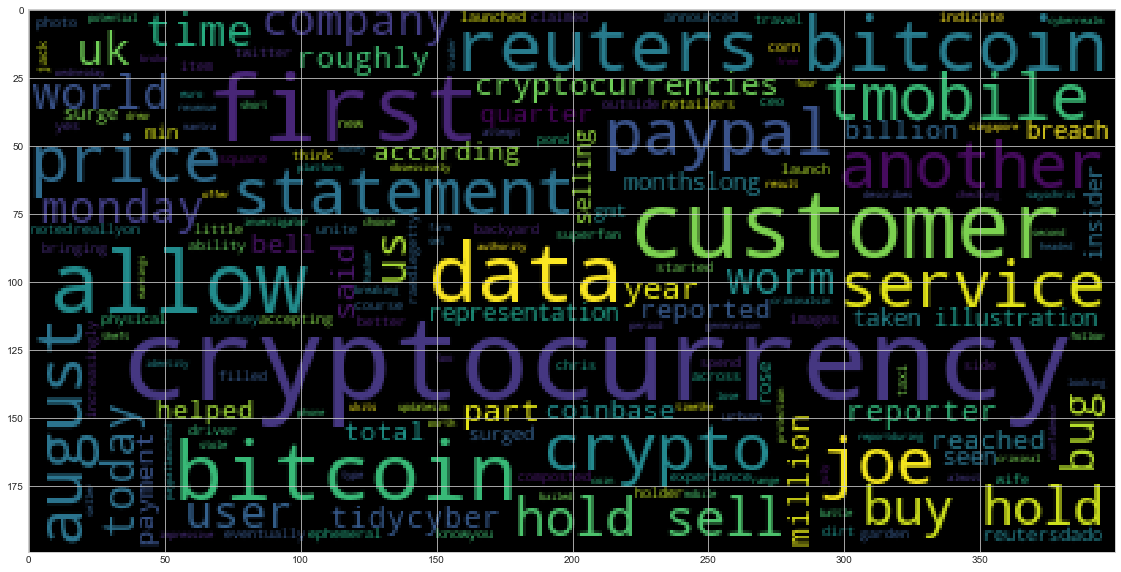

In [273]:
# Generate the Bitcoin word cloud
btc_string = ' '.join([x for v in btc_df['tokens'] for x in v])
btc_wc = WordCloud().generate(btc_string)
plt.imshow(btc_wc)

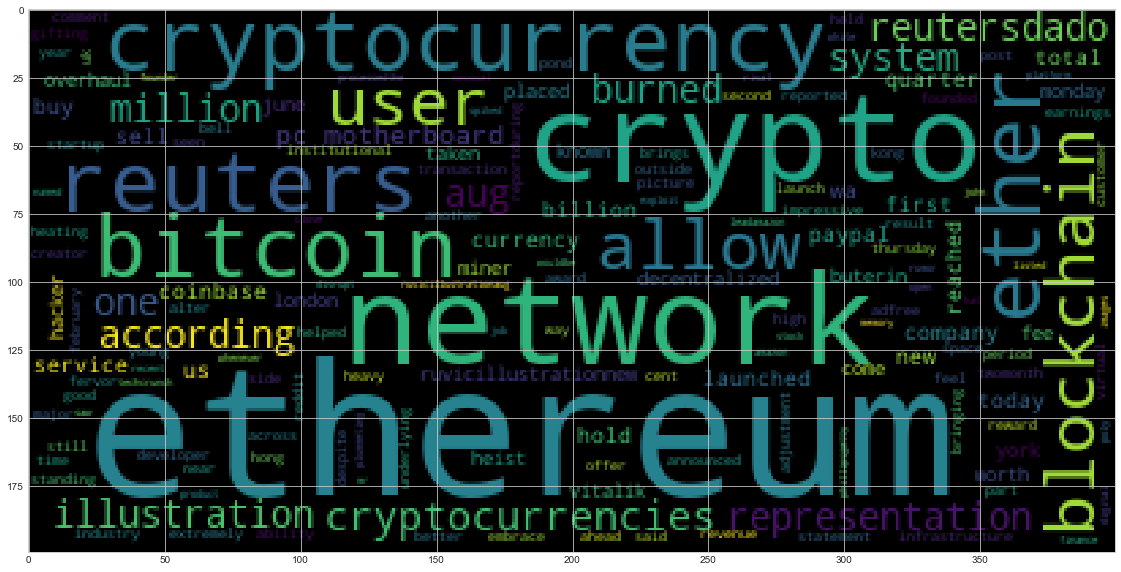

In [274]:
# Generate the Ethereum word cloud
eth_string = ' '.join([x for v in eth_df['tokens'] for x in v])
eth_wc = WordCloud().generate(eth_string)
plt.imshow(eth_wc)

---
## 3. Named Entity Recognition

In this section, you will build a named entity recognition model for both Bitcoin and Ethereum, then visualize the tags using SpaCy.

In [275]:
import spacy
from spacy import displacy

In [276]:
# Download the language model for SpaCy
# !python -m spacy download en_core_web_sm

In [277]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

---
### Bitcoin NER

In [278]:
# Concatenate all of the Bitcoin text together
btc_text = ' '.join(btc_df['content'].values)

In [279]:
# Run the NER processor on all of the text
btc_doc = nlp(btc_text)

# Add a title to the document
btc_doc.user_data['title'] = 'BTC Analysis w/ NER'

In [280]:
# Render the visualization
displacy.render(btc_doc, style='ent')

In [281]:
# List all Entities
[ent for ent in btc_doc.ents]

[U.S.,
 first,
 today,
 U.K.,
 Photo,
 Joe Raedle,
 Twitter,
 Square,
 Jack Dorsey,
 Monday,
 a year,
 US,
 Joe TidyCyber,
 Chris,
 almost 2,500,
 2,100,
 Chris,
 Joe TidyCyber,
 T-Mobile,
 two years,
 roughly 49 million,
 today,
 Coinbase,
 its second quarter,
 the quarter,
 Coinbase,
 $2.23 billion,
 UK,
 first,
 four,
 SINGAPORE,
 July 28,
 Reuters,
 40,000,
 Wednesday,
 first,
 $311 billion,
 Q2 2021,
 Insider T-Mobile,
 Motherboard,
 August 6, 2021,
 REUTERS,
 Dado Ruvic/IllustrationAug,
 20,
 Reuters,
 5.01 %,
 49,106.4,
 22:04 GMT,
 August
 20, 2021,
 PennyStocksBitcoin Price Surge Helped Boost,
 Bitcoin, Dogecoin,
 Ethereum,
 T-Mobile,
 Roughly 47.8 million,
 June 7, 2021,
 REUTERS,
 Edgar Su/IllustrationAug,
 Reuters,
 7.07%,
 47,587.38,
 2200,
 REUTERS,
 Dado Ruvic/Illustration
 Welcome,
 10,
 the Opening Bell,
 first,
 August,
 24, 2021,
 Entrepreneur,
 El Salvador’s,
 Bitcoin ,
 LONDON,
 Aug 23,
 Reuters,
 50,000,
 Monday,
 first,
 May,
 months-long]

---

### Ethereum NER

In [282]:
# Concatenate all of the Ethereum text together
eth_text = ' '.join(eth_df['content'].values)

In [283]:
# Run the NER processor on all of the text
eth_doc = nlp(eth_text)

# Add a title to the document
eth_doc.user_data['title'] = 'ETH Analysis w/ NER'

In [284]:
# Render the visualization
displacy.render(eth_doc, style='ent')

In [285]:
# List all Entities
[ent for ent in eth_doc.ents]

[2017,
 Reddit,
 Ethereum,
 U.S.,
 first,
 today,
 U.K.,
 today,
 Coinbase,
 its second quarter,
 the quarter,
 Coinbase,
 $2.23 billion,
 a year,
 US,
 Ethereum,
 February 3, 2018,
 REUTERS,
 Dado Ruvic,
 Aug 5,
 Reuters,
 Aug 5,
 Reuters,
 two-month,
 Thursday,
 One,
 Monday,
 Poly Network,
 White,
 Ethereum,
 June 29, 2021,
 REUTERS,
 Dado Ruvic/IllustrationAug 3,
 Reuters,
 Monday,
 Amazon,
 Amazon,
 Vitalik Buterin,
 TechCrunch Disrupt London 2015,
 John Phillips,
 Vitalik Buterin,
 Mary-Ann RussonBusiness,
 BBC News,
 almost half,
 $600m,
 433,
 Yesterday,
 Justin Sullivan,
 Getty Images,
 CoinDesk,
 two,
 one,
 Ethereum,
 June 29, 2021,
 REUTERS,
 Dado Ruvic,
 July 30,
 Reuters,
 LONDON,
 Aug 25,
 Reuters,
 September,
 More than $144 million,
 August 5,
 Sunday,
 over 45,799,
 second,
 Dado Ruvic,
 Reuters,
 More than $144 million,
 first,
 $311 billion,
 Q2 2021,
 Insider All,
 Livepeer,
 $20 million,
 Ethereum,
 Ethereum]

---